1. Faça o processamento dos dados que vimos durante as últimas aulas para prever o preço da ação da AMAZON (coluna Close) base `acao_amazon.csv`.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('acao_amazon.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [5]:
features = data[['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day']]
target = data['Close']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = model.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [10]:
mse, r2

(4.8915412315146725, 0.9999344100303552)


2. Separe 15% dos dados para teste e utilize 10% dos dados de treinamento como dados de validação durante o treinamento.


In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.10, random_state=42)

In [13]:
len(X_train), len(X_val), len(X_test)

(2309, 257, 453)


3. Treine um modelo de RNN, outro de GRU e outro de LSTM, cada um com 5 camadas contendo 50, 40, 30, 20 e 10 neurônios, respectivamente.


In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

In [15]:
def create_sequences(data, target, window_size=5):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [16]:
window_size = 5
X_train_seq, y_train_seq = create_sequences(scaled_data[:len(X_train)], y_train.values, window_size)
X_val_seq, y_val_seq = create_sequences(scaled_data[len(X_train):len(X_train)+len(X_val)], y_val.values, window_size)
X_test_seq, y_test_seq = create_sequences(scaled_data[len(X_train)+len(X_val):], y_test.values, window_size)

In [17]:
X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape

((2304, 5, 7), (2304,), (252, 5, 7), (252,), (448, 5, 7), (448,))

In [18]:
def build_model(model_type='RNN'):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(50, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])))
        model.add(SimpleRNN(40, return_sequences=True))
        model.add(SimpleRNN(30, return_sequences=True))
        model.add(SimpleRNN(20, return_sequences=True))
        model.add(SimpleRNN(10))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])))
        model.add(GRU(40, return_sequences=True))
        model.add(GRU(30, return_sequences=True))
        model.add(GRU(20, return_sequences=True))
        model.add(GRU(10))
    elif model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])))
        model.add(LSTM(40, return_sequences=True))
        model.add(LSTM(30, return_sequences=True))
        model.add(LSTM(20, return_sequences=True))
        model.add(LSTM(10))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [19]:
rnn_model = build_model('RNN')
gru_model = build_model('GRU')
lstm_model = build_model('LSTM')

In [20]:
history_rnn = rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=10, batch_size=32)
history_gru = gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=10, batch_size=32)
history_lstm = lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=10, batch_size=32)

Epoch 1/10
72/72 [==============================] - 23s 21ms/step - loss: 169237.8594 - val_loss: 172162.6406
Epoch 2/10
72/72 [==============================] - 1s 11ms/step - loss: 168553.5625 - val_loss: 171627.5156
Epoch 3/10
72/72 [==============================] - 1s 11ms/step - loss: 168050.7031 - val_loss: 171125.3594
Epoch 4/10
72/72 [==============================] - 1s 16ms/step - loss: 167568.9219 - val_loss: 170635.5312
Epoch 5/10
72/72 [==============================] - 1s 16ms/step - loss: 167093.7969 - val_loss: 170154.7812
Epoch 6/10
72/72 [==============================] - 1s 16ms/step - loss: 166624.4844 - val_loss: 169675.0469
Epoch 7/10
72/72 [==============================] - 1s 15ms/step - loss: 166158.6875 - val_loss: 169199.1406
Epoch 8/10
72/72 [==============================] - 1s 11ms/step - loss: 165696.4375 - val_loss: 168724.8594
Epoch 9/10
72/72 [==============================] - 1s 11ms/step - loss: 165236.2812 - val_loss: 168256.4062
Epoch 10/10
72/72 


4. Coloque Dropout de 15% após as camadas com 50 e 20 neurônios.


In [21]:
def build_model_with_dropout(model_type='RNN'):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(50, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])))
        model.add(Dropout(0.15))
        model.add(SimpleRNN(40, return_sequences=True))
        model.add(SimpleRNN(30, return_sequences=True))
        model.add(SimpleRNN(20, return_sequences=True))
        model.add(Dropout(0.15))
        model.add(SimpleRNN(10))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])))
        model.add(Dropout(0.15))
        model.add(GRU(40, return_sequences=True))
        model.add(GRU(30, return_sequences=True))
        model.add(GRU(20, return_sequences=True))
        model.add(Dropout(0.15))
        model.add(GRU(10))
    elif model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])))
        model.add(Dropout(0.15))
        model.add(LSTM(40, return_sequences=True))
        model.add(LSTM(30, return_sequences=True))
        model.add(LSTM(20, return_sequences=True))
        model.add(Dropout(0.15))
        model.add(LSTM(10))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


5. Treine os modelos por 20 épocas.


In [22]:
rnn_model = build_model_with_dropout('RNN')
gru_model = build_model_with_dropout('GRU')
lstm_model = build_model_with_dropout('LSTM')

In [23]:
history_rnn = rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=20, batch_size=32)
history_gru = gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=20, batch_size=32)
history_lstm = lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=20, batch_size=32)

Epoch 1/20
72/72 [==============================] - 9s 29ms/step - loss: 168994.3125 - val_loss: 171765.5312
Epoch 2/20
72/72 [==============================] - 1s 12ms/step - loss: 168181.4688 - val_loss: 171229.9688
Epoch 3/20
72/72 [==============================] - 1s 12ms/step - loss: 167667.8125 - val_loss: 170725.9219
Epoch 4/20
72/72 [==============================] - 1s 12ms/step - loss: 167179.7500 - val_loss: 170234.3125
Epoch 5/20
72/72 [==============================] - 1s 11ms/step - loss: 166701.2969 - val_loss: 169749.7812
Epoch 6/20
72/72 [==============================] - 1s 11ms/step - loss: 166229.3906 - val_loss: 169266.7344
Epoch 7/20
72/72 [==============================] - 1s 12ms/step - loss: 165761.5312 - val_loss: 168788.2969
Epoch 8/20
72/72 [==============================] - 1s 12ms/step - loss: 165298.2969 - val_loss: 168315.6875
Epoch 9/20
72/72 [==============================] - 1s 12ms/step - loss: 164838.3438 - val_loss: 167846.1875
Epoch 10/20
72/72 [


6. Salve o history e exiba os valores de loss de treinamento e validação para os três modelos.


In [24]:
import pickle
with open('history_rnn.pkl', 'wb') as f:
    pickle.dump(history_rnn.history, f)
with open('history_gru.pkl', 'wb') as f:
    pickle.dump(history_gru.history, f)
with open('history_lstm.pkl', 'wb') as f:
    pickle.dump(history_lstm.history, f)

In [25]:
def plot_history(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [26]:
with open('history_rnn.pkl', 'rb') as f:
    history_rnn = pickle.load(f)

with open('history_gru.pkl', 'rb') as f:
    history_gru = pickle.load(f)

with open('history_lstm.pkl', 'rb') as f:
    history_lstm = pickle.load(f)

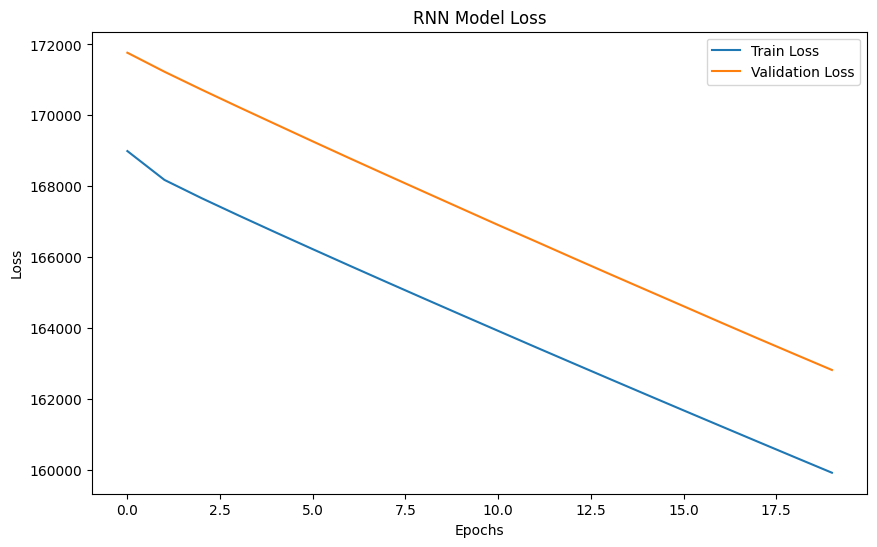

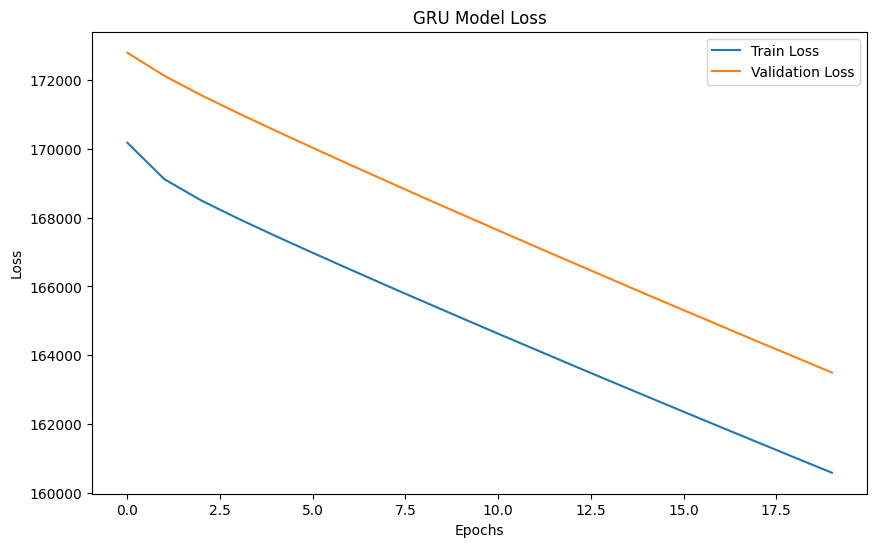

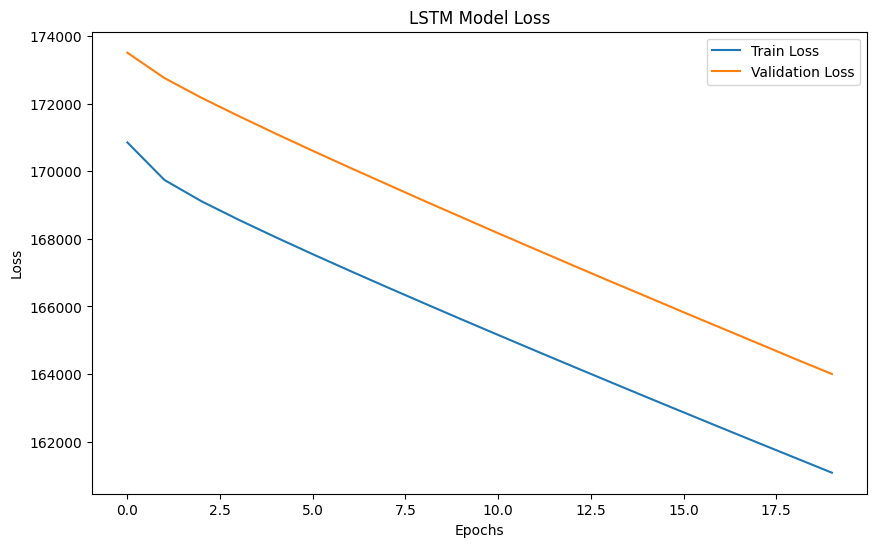

In [27]:
plot_history(history_rnn, 'RNN Model Loss')
plot_history(history_gru, 'GRU Model Loss')
plot_history(history_lstm, 'LSTM Model Loss')


7. Exiba as métricas MSE, MAE, RMSE e R² para os dados de treinamento e teste dos três modelos.


In [28]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)

    return mse_train, mae_train, rmse_train, r2_train, mse_test, mae_test, rmse_test, r2_test

In [29]:
rnn_metrics = evaluate_model(rnn_model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)
gru_metrics = evaluate_model(gru_model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)
lstm_metrics = evaluate_model(lstm_model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)

14/14 [==============================] - 0s 21ms/step


In [30]:
print("RNN Metrics (Train MSE, Train MAE, Train RMSE, Train R², Test MSE, Test MAE, Test RMSE, Test R²):", rnn_metrics)
print("GRU Metrics (Train MSE, Train MAE, Train RMSE, Train R², Test MSE, Test MAE, Test RMSE, Test R²):", gru_metrics)
print("LSTM Metrics (Train MSE, Train MAE, Train RMSE, Train R², Test MSE, Test MAE, Test RMSE, Test R²):", lstm_metrics)

RNN Metrics (Train MSE, Train MAE, Train RMSE, Train R², Test MSE, Test MAE, Test RMSE, Test R²): (159712.0402571146, 283.22281427241035, 399.6398882207763, -1.0090353781803096, 138787.33615554133, 257.55707649026596, 372.5417240465037, -0.9155845617790803)
GRU Metrics (Train MSE, Train MAE, Train RMSE, Train R², Test MSE, Test MAE, Test RMSE, Test R²): (160368.62078273622, 284.3795753002829, 400.4605108905699, -1.017294577063966, 139384.53282983092, 258.71382683719906, 373.34238016843324, -0.9238272499183848)
LSTM Metrics (Train MSE, Train MAE, Train RMSE, Train R², Test MSE, Test MAE, Test RMSE, Test R²): (160857.72357900246, 285.2382266146276, 401.07072141830855, -1.0234470551093526, 139829.53388767256, 259.57242794326373, 373.93787436908895, -0.929969288378014)
